## Stack Overflow Tag Analysis

The Stack Overflow dataset is a seminal dataset used by tech market researchers, because it is open, comprehensive, and behavioral in nature. It was first made available for public consumption in 2010, and encompasses not just questions and answer posts from the developer community but also technology tags associated with each post. As a result, these tags act as a good market proxy of user adoption, interest or disterest from a behavioral perspective: the more posts with a certain tag, the more indicative interest of that certain tag. The time series nature of this dataset also make it possible to gauge the waxing and waning of a tag, while also indicating changing affiliation among tags. Finally, additional metadata about users, badge contests and an annual developer survey provide additional context to help make business/actionable decisions, leading to measurable outcomes.

Thus, for my capstone project I would like to analyze technology tags in the Stack Overflow dataset in order to better understand technology adoption curves and affiliations among technologies, depending on certain cohorts of developers. My team and I at Microsoft perfomed a similar analysis in 2016, where we found that OSS developers gravitated towards AWS and Google, as there were very few OSS offerings on Azure. We also realized that Microsoft had not reached out to OSS developers proactively, even with the limited offers. This 'wake up call' generated massive investment in development and marketing of OSS technologies on the Azure cloud/platform.

Five years later, Microsoft would like to know if their efforts have paid off. They have seen fantastic growth in their OSS services and technologies, but are they keeping up with the market? Have they been able bring new developers onto their platform, or is this adoption coming from existing developers who have become 'polyglots'? And have the 'islands of technologies' that used to center around just AWS and Google begun to diffuse and include Azure? ...or is Azure still an island unto itself?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from scipy import stats
import datetime

# pipelines
from sklearn.pipeline import Pipeline

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# NLP transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# classifiers you can use
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, fbeta_score

In [2]:
# posts = pd.read_csv("/Users/bens_mac/Documents/CodingNomads/SO_posts_BIG.csv")
users = pd.read_csv("/Users/bens_mac/Documents/CodingNomads/SO_users_BIG.csv")

In [57]:
users.head()

,id,display_name,creation_date,reputation
0,14712167,nicom,2020-11-26 09:26:50.507000+00:00,19
1,14717603,Donkey,2020-11-27 05:56:10.180000+00:00,43
2,14785218,redshorts17,2020-12-08 07:42:10.147000+00:00,89
3,14808842,PerekatovSergey,2020-12-11 16:09:17.147000+00:00,26
4,14916620,leung2,2020-12-31 03:02:17.930000+00:00,33


In [58]:
users = users[['id', 'display_name', 'creation_date', 'reputation']]

In [68]:
users['creation_date'] = pd.to_datetime(users['creation_date'])

In [107]:
users_toy = users.head(1000000)

In [108]:
years = []
for i in users_toy['creation_date']:
    years.append(i.year)

    
users_toy['creation_date'] = years

users_toy

<ipython-input-108-3ec613809367>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_toy['creation_date'] = years


,id,display_name,creation_date,reputation
0,14712167,nicom,2020,19
1,14717603,Donkey,2020,43
2,14785218,redshorts17,2020,89
3,14808842,PerekatovSergey,2020,26
4,14916620,leung2,2020,33
...,...,...,...,...
999995,14842022,jack,2020,1
999996,14844384,Gokhawk,2020,1
999997,14844729,Annalis Parra,2020,1
999998,14848028,Hung Trinh,2020,1


In [109]:
users__toy_2021 = users_toy.loc[users_toy['creation_date'] == 2021].sort_values(by = 'reputation', ascending = False)
users__toy_2020 = users_toy.loc[users_toy['creation_date'] == 2020].sort_values(by = 'reputation', ascending = False)
users__toy_2019 = users_toy.loc[users_toy['creation_date'] == 2019].sort_values(by = 'reputation', ascending = False)
users__toy_2018 = users_toy.loc[users_toy['creation_date'] == 2018].sort_values(by = 'reputation', ascending = False)
users__toy_2017 = users_toy.loc[users_toy['creation_date'] == 2017].sort_values(by = 'reputation', ascending = False)
users__toy_2016 = users_toy.loc[users_toy['creation_date'] == 2016].sort_values(by = 'reputation', ascending = False)

In [113]:
users__toy_2017.describe()

,id,creation_date,reputation
count,6.694900e+04,66949.0,66949.000000
mean,8.236243e+06,2017.0,106.659144
std,5.271720e+05,0.0,1180.423367
min,7.361683e+06,2017.0,1.000000
25%,7.782902e+06,2017.0,1.000000
50%,8.220895e+06,2017.0,15.000000
75%,8.680807e+06,2017.0,71.000000
max,1.511927e+07,2017.0,246843.000000


In [ ]:
posts.dropna()

In [ ]:
posts['tags'] = posts['tags'].str.split("|")
posts['creation_date'] = [x[:4] for x in posts['creation_date']]
posts['last_activity_date'] = [x[:4] for x in posts['last_activity_date']]

In [ ]:
users['creation_date'] = [x[:4] for x in users['creation_date']]
users['last_access_date'] = [x[:4] for x in users['last_access_date']]

In [ ]:
posts['creation_date'] = posts['creation_date'].astype(str).astype(float)
posts['last_activity_date'] = posts['last_activity_date'].astype(str).astype(float)

In [ ]:
posts.info()

In [ ]:
posts_proto = posts.sample(n=10000)

In [ ]:
posts_proto.info()

In [ ]:
posts_proto = posts_proto.dropna()

In [ ]:
print(posts_proto)

In [ ]:
all_tags_proto = posts_proto['tags']

In [ ]:
all_tags_proto[0:15]

In [ ]:
#all tags of postgres + ...
#all tags of mysql + ...
#all tags of mariadb + ...
#all tags of sql-server + ...


postgres = []
element = "postgres"
for tag_list in all_tags_proto:
    for tag in tag_list:
        if element in tag:
            postgres.append(tag_list)
            
            
#creating X
postgres_features = []
for x_list in postgres:
    for x in x_list:
        postgres_features.append(x)
for i in postgres_features:
    if "postgres" in postgres_features:
        postgres_features.remove("postgres")


#creating y
postgres_label = []
for i in range(len(postgres_features)):
    postgres_label.append("postgres")

print(len(postgres)) #postgres could come up as a single tag in a post.
print(len(postgres_features))
print(len(postgres_label))

In [ ]:
mysql = []
element = "mysql"
for tag_list in all_tags_proto:
        if element in tag_list:
            mysql.append(tag_list)

#creating X
mysql_features = []
for x_list in mysql:
    for x in x_list:
        mysql_features.append(x)
for i in mysql_features:
    if "mysql" in mysql_features:
        mysql_features.remove("mysql")

#creating y
mysql_label = []
for i in range(len(mysql_features)):
    mysql_label.append("mysql")

print(len(mysql)) 
print(len(mysql_features))
print(len(mysql_label))

In [ ]:
mariadb = []
element = "mariadb"
for tag_list in all_tags_proto:
        if element in tag_list:
            mariadb.append(tag_list)
# mariadb = [' '.join([str(c) for c in lst]) for lst in mariadb]



print(mariadb)

#creating X
mariadb_features = []
for x_list in mariadb:
    for x in x_list:
        mariadb_features.append(x)
for i in mariadb_features:
    if "mariadb" in mariadb_features:
        mariadb_features.remove("mariadb")
    
#print(mariadb_features)

#creating y
mariadb_label = []
for i in range(len(mariadb_features)):
    mariadb_label.append("mariadb")

#print(len(mariadb)) #mariadb could come up as a single tag in a post.
print(mariadb_features)
print(len(mariadb))
print(len(mariadb_features))
print(len(mariadb_label))

In [ ]:
sql_server = []
element = "sql-server"
for tag_list in all_tags_proto:
        if element in tag_list:
            sql_server.append(tag_list)
            
#creating X
sql_server_features = []
for x_list in sql_server:
    for x in x_list:
        sql_server_features.append(x)
for i in sql_server_features:
    if "sql-server" in sql_server_features:
        sql_server_features.remove("sql-server")

#creating y
sql_server_label = []
for i in range(len(sql_server_features)):
    sql_server_label.append("sql_server")

print(len(sql_server)) #sql_server could come up as a single tag in a post.
print(len(sql_server_label))
print(len(sql_server_features))
print(type(sql_server_features))

In [ ]:
X = np.concatenate((postgres_features, mysql_features, mariadb_features, sql_server_features), axis = 0 )
y = np.concatenate((postgres_label, mysql_label, mariadb_label, sql_server_label), axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3)

In [ ]:
print(X_train[:10])

In [ ]:
#Baseline Model

dummy = DummyClassifier(strategy='most_frequent')
scores = cross_val_score(dummy, X_train, y_train, cv=3, scoring = "accuracy") 
print (f"{scores.mean()} is the mean score")
scores

In [ ]:
# create the pipeline
dt_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),('clf', DecisionTreeClassifier())])
# pass the pipeline as if it was the classifier into a cross validation method
# the cv method will automatically figure out what to do.
scores = cross_val_score(dt_pipe, X_train, y_train, cv=4, scoring = 'accuracy')
print(f"the mean score is: {scores.mean()}")
print("The scores were:", scores)

# Summary of the DTC analysis: dunno

In [ ]:
top_tags = posts_proto['tags'].value_counts().head(50)

In [ ]:
print(top_tags)

# Moving on to User analysis

In [ ]:
#No added information about age
users = users.drop(columns = 'age')

# Adding StackOverflow Survey Data

In [4]:
df_20 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2020/survey_results_public.csv')
# df_19 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2019/survey_results_public.csv')
# df_18 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2018/survey_results_public.csv')
def prettify(ax):
  ax.grid(False)
  ax.set_frame_on(False)
  ax.tick_params(top=False, bottom=False, left=False, right=False, labelbottom=False)

In [5]:
rev_data_20 = df_20[['Respondent', 'Country', 'Age1stCode', 'UndergradMajor','Hobbyist', 'Employment','DevType', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'PlatformDesireNextYear', 'PlatformWorkedWith']]

In [6]:
rev_data_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Respondent              64461 non-null  int64 
 1   Country                 64072 non-null  object
 2   Age1stCode              57900 non-null  object
 3   UndergradMajor          50995 non-null  object
 4   Hobbyist                64416 non-null  object
 5   Employment              63854 non-null  object
 6   DevType                 49370 non-null  object
 7   DatabaseDesireNextYear  44070 non-null  object
 8   DatabaseWorkedWith      49537 non-null  object
 9   PlatformDesireNextYear  50605 non-null  object
 10  PlatformWorkedWith      53843 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.4+ MB


In [7]:
rev_data_20.head(5)

,Respondent,Country,Age1stCode,UndergradMajor,Hobbyist,Employment,DevType,DatabaseDesireNextYear,DatabaseWorkedWith,PlatformDesireNextYear,PlatformWorkedWith
0,1,Germany,13,"Computer science, computer engineering, or sof...",Yes,"Independent contractor, freelancer, or self-em...","Developer, desktop or enterprise applications;...",Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows
1,2,United Kingdom,19,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack;Developer, mobile",NaN,NaN,iOS;Kubernetes;Linux;MacOS,iOS
2,3,Russian Federation,15,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Albania,18,"Computer science, computer engineering, or sof...",Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,5,United States,16,"Computer science, computer engineering, or sof...",Yes,Employed full-time,NaN,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,Docker;Google Cloud Platform;Heroku;Linux;Windows,AWS;Docker;Linux;MacOS;Windows


In [8]:
country_20 = rev_data_20['Country'].value_counts()
top_country_20 = country_20.head(30).sort_values(ascending = True)

<AxesSubplot:title={'center':'Number of Developers from Countries'}>

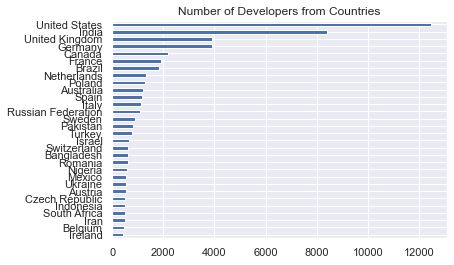

In [9]:
top_country_20.plot(kind = 'barh', title = 'Number of Developers from Countries')

In [10]:
dev_types = ['Developer, back-end', 
             'Developer, full-stack', 
             'Developer, front-end', 
             'Developer, desktop or enterprise applications', 
             'Developer, mobile', 
             'DevOps specialist',
             'Database administrator',
             'Designer',
             'System administrator',
             'Developer, embedded applications or devices',
             'Data or business analyst',
             'Data scientist or machine learning specialist',
             'Developer, QA or test',
             'Engineer, data'
            ]

In [11]:
rslt_df = rev_data_20.loc[rev_data_20['DevType'].isin(dev_types)]

In [12]:
rslt_df.head()

,Respondent,Country,Age1stCode,UndergradMajor,Hobbyist,Employment,DevType,DatabaseDesireNextYear,DatabaseWorkedWith,PlatformDesireNextYear,PlatformWorkedWith
8,9,Tunisia,20,"Computer science, computer engineering, or sof...",No,"Independent contractor, freelancer, or self-em...","Developer, full-stack",NaN,NaN,NaN,WordPress
16,17,United States,14,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, full-stack",Cassandra;Elasticsearch;MariaDB;PostgreSQL;Redis,Microsoft SQL Server;PostgreSQL,Docker;Kubernetes;Microsoft Azure,NaN
17,18,United States,12,"Computer science, computer engineering, or sof...",Yes,Employed full-time,"Developer, back-end",Elasticsearch;PostgreSQL;Redis;SQLite,Elasticsearch;MariaDB;MySQL;Redis;SQLite,Linux,AWS;Linux
18,19,United States,15,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack",MariaDB;MongoDB,MariaDB;Microsoft SQL Server,iOS;Slack Apps and Integrations,Windows
19,20,Spain,18,"Another engineering discipline (such as civil,...",Yes,Employed full-time,"Developer, desktop or enterprise applications",NaN,IBM DB2;MariaDB;Microsoft SQL Server;MySQL,NaN,Heroku;Linux;Windows


In [13]:
df = pd.concat([rslt_df, rslt_df['DatabaseWorkedWith'].str.split(';', expand=True)], axis=1)

In [14]:
df_dbs = df.rename(columns = {0: "CurrentDB0",
                     1: "CurrentDB1",
                     2: "CurrentDB2",
                     3: "CurrentDB3",
                     4: "CurrentDB4", 
                     5:"CurrentDB5",
                     6:"CurrentDB6",
                     7:"CurrentDB7",
                     8:"CurrentDB8",
                     9:"CurrentDB9",
                     10:"CurrentDB10",
                     11:"CurrentDB11",
                     12:"CurrentDB12",
                     13:"CurrentDB13",})

In [15]:
df_db_desired = pd.concat([df_dbs, df_dbs['DatabaseDesireNextYear'].str.split(';', expand=True)], axis=1)

In [16]:
df_db_desired = df_db_desired.rename(columns = {0: "DesiredDB0",
                     1: "DesiredDB1",
                     2: "DesiredDB2",
                     3: "DesiredDB3",
                     4: "DesiredDB4", 
                     5:"DesiredDB5",
                     6:"DesiredB6",
                     7:"DesiredDB7",
                     8:"DesiredDB8",
                     9:"DesiredDB9",
                     10:"DesiredDB10",
                     11:"DesiredDB11",
                     12:"DesiredDB12",
                     13:"DesiredDB13",})

In [17]:
df_platform_desired = pd.concat([df_db_desired, df_db_desired['PlatformDesireNextYear'].str.split(';', expand=True)], axis=1)

In [18]:
df_platform_desired = df_platform_desired.rename(columns = {0: "DesiredPlatform0",
                     1: "DesiredPlatform1",
                     2: "DesiredPlatform2",
                     3: "DesiredPlatform3",
                     4: "DesiredPlatform4", 
                     5:"DesiredPlatform5",
                     6:"DesiredPlatform6",
                     7:"DesiredPlatform7",
                     8:"DesiredPlatform8",
                     9:"DesiredPlatform9",
                     10:"DesiredPlatform10",
                     11:"DesiredPlatform11",
                     12:"DesiredPlatform12",
                     13:"DesiredPlatform13",
                    14:"DesiredPlatform14",
                     15:"DesiredPlatform15",                                 
                                                           })

In [19]:
df_platform_desired_toy = df_platform_desired[['CurrentDB0', 'DesiredDB0', 'DesiredPlatform0']]

In [20]:
df_platform_desired_toy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CurrentDB0        9981 non-null   object
 1   DesiredDB0        8716 non-null   object
 2   DesiredPlatform0  10131 non-null  object
dtypes: object(3)
memory usage: 400.2+ KB


In [21]:
df = df_platform_desired_toy.dropna()
print(len(df))
print(df)

7654
                 CurrentDB0            DesiredDB0 DesiredPlatform0
16     Microsoft SQL Server             Cassandra           Docker
17            Elasticsearch         Elasticsearch            Linux
18                  MariaDB               MariaDB              iOS
23               PostgreSQL             Cassandra              AWS
36                  MariaDB         Elasticsearch           Docker
...                     ...                   ...              ...
64416  Microsoft SQL Server  Microsoft SQL Server          Android
64420                Oracle              Firebase          Android
64422                 MySQL               MongoDB          Android
64428               MariaDB               MariaDB          Android
64429              Firebase              Firebase          Android

[7654 rows x 3 columns]


In [22]:
def count_db(df, column_string,db_name):
    '''Count the number of current or desired databases'''
    
    counter = 0
    for i in df[column_string]:
        if i == db_name:
            counter += 1
    return counter
    

In [23]:
Cur_MySQL = count_db(df, "CurrentDB0","MySQL")
Cur_PostgreSQL = count_db(df, "CurrentDB0","PostgreSQL")
Cur_Microsoft_SQL_Server = count_db(df, "CurrentDB0","Microsoft SQL Server")
Cur_SQLite = count_db(df, "CurrentDB0","SQLite")
Cur_MongoDB = count_db(df, "CurrentDB0","MongoDB")
Cur_Redis = count_db(df, "CurrentDB0","Redis")
Cur_MariaDB = count_db(df, "CurrentDB0","MariaDB")
Cur_Oracle = count_db(df, "CurrentDB0","Oracle")
Cur_Firebase = count_db(df, "CurrentDB0","Firebase")
Cur_Elasticsearch = count_db(df, "CurrentDB0","Elasticsearch")
Cur_DynamoDB = count_db(df, "CurrentDB0","DynamoDB")
Cur_Cassandra = count_db(df, "CurrentDB0","Cassandra")
Cur_IBM_DB2 = count_db(df, "CurrentDB0","IBM DB2")
Cur_Couchbase= count_db(df, "CurrentDB0","Couchbase")

Current_DBs = [
Cur_MySQL,
Cur_PostgreSQL,
Cur_Microsoft_SQL_Server,
Cur_SQLite,
Cur_MongoDB,
Cur_Redis,
Cur_MariaDB,
Cur_Oracle,
Cur_Firebase,
Cur_Elasticsearch,
Cur_DynamoDB,
Cur_Cassandra,
Cur_IBM_DB2,
Cur_Couchbase
]

sum = 0
for i in Current_DBs:
    sum += i
print(sum)

7654


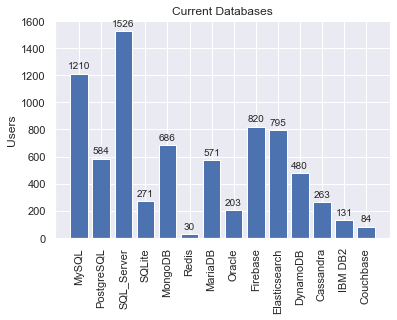

In [24]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Databases')

# ax.bar(x - width/2, Current_DBs, width, label='Current_DBs')

pps = plt.bar(labels,Current_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [25]:
Des_MySQL = count_db(df, "DesiredDB0","MySQL")
Des_PostgreSQL = count_db(df, "DesiredDB0","PostgreSQL")
Des_Microsoft_SQL_Server = count_db(df, "DesiredDB0","Microsoft SQL Server")
Des_SQLite = count_db(df, "DesiredDB0","SQLite")
Des_MongoDB = count_db(df, "DesiredDB0","MongoDB")
Des_Redis = count_db(df, "DesiredDB0","Redis")
Des_MariaDB = count_db(df, "DesiredDB0","MariaDB")
Des_Oracle = count_db(df, "DesiredDB0","Oracle")
Des_Firebase = count_db(df, "DesiredDB0","Firebase")
Des_Elasticsearch = count_db(df, "DesiredDB0","Elasticsearch")
Des_DynamoDB = count_db(df, "DesiredDB0","DynamoDB")
Des_Cassandra = count_db(df, "DesiredDB0","Cassandra")
Des_IBM_DB2 = count_db(df, "DesiredDB0","IBM DB2")
Des_Couchbase= count_db(df, "DesiredDB0","Couchbase")

Desired_DBs = [
Des_MySQL,
Des_PostgreSQL,
Des_Microsoft_SQL_Server,
Des_SQLite,
Des_MongoDB,
Des_Redis,
Des_MariaDB,
Des_Oracle,
Des_Firebase,
Des_Elasticsearch,
Des_DynamoDB,
Des_Cassandra,
Des_IBM_DB2,
Des_Couchbase
]

sum = 0
for i in Desired_DBs:
    sum += i
print(sum)

7654


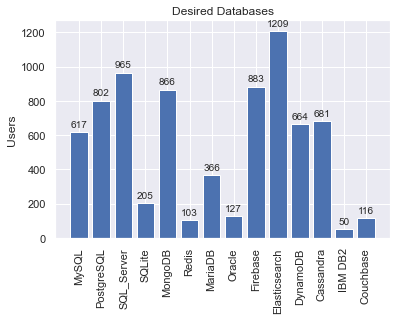

In [26]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Databases')

pps = plt.bar(labels,Desired_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [27]:
def count_platforms(df, column_string,platform_name):
    '''Count the number of desired platforms'''
    
    counter = 0
    for i in df[column_string]:
        if i == platform_name:
            counter += 1
    return counter


In [28]:
# Linux
# Windows
# Docker
# AWS
# Android
# MacOS
# Rasberry Pi
# Microsoft Azure
# WordPress
# Google Cloud Platform
# iOS
# Kubernetes
# Heroku
# Arduino
# Slack Apps and Integrations
# IBM Cloud or Watson

Linux = count_platforms(df, "DesiredPlatform0","Linux")
Windows = count_platforms(df, "DesiredPlatform0","Windows")
Docker = count_platforms(df, "DesiredPlatform0","Docker")
AWS = count_platforms(df, "DesiredPlatform0","AWS")
Android = count_platforms(df, "DesiredPlatform0","Android")
MacOS = count_platforms(df, "DesiredPlatform0","MacOS")
Raspberry_Pi = count_platforms(df, "DesiredPlatform0","Raspberry Pi")
Azure = count_platforms(df, "DesiredPlatform0","Microsoft Azure")
WordPress = count_platforms(df, "DesiredPlatform0","WordPress")
Google = count_platforms(df, "DesiredPlatform0","Google Cloud Platform")
iOS = count_platforms(df, "DesiredPlatform0","iOS")
Kubernetes = count_platforms(df, "DesiredPlatform0","Kubernetes")
Heroku = count_platforms(df, "DesiredPlatform0","Heroku")
Arduino= count_platforms(df, "DesiredPlatform0","Arduino")
Slack = count_platforms(df, "DesiredPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df, "DesiredPlatform0","IBM Cloud or Watson")

Desired_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Desired_Platforms:
    sum += i
print(sum)


7654


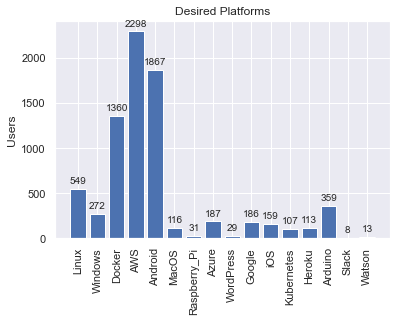

In [29]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Platforms')

pps = plt.bar(labels,Desired_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [30]:
X = pd.get_dummies(df, columns= ['CurrentDB0', 'DesiredDB0'])

In [31]:
def desired_platform_y(df, column_string, label):
    
    label_name = []
    for i in df[column_string]:
        if i == label:
            label_name.append(1)
        else:
            label_name.append(0) 
    return label_name

Azure_y = (desired_platform_y(df, 'DesiredPlatform0', "Microsoft Azure"))
AWS_y = (desired_platform_y(df, 'DesiredPlatform0', "AWS"))
Google_y = (desired_platform_y(df, 'DesiredPlatform0', "Google Cloud Platform"))
Android_y = (desired_platform_y(df, 'DesiredPlatform0', "Android"))
Docker_y = (desired_platform_y(df, 'DesiredPlatform0', "Docker"))
Linux_y = (desired_platform_y(df, 'DesiredPlatform0', "Linux"))
np.count_nonzero(Google_y)

186

In [32]:
X = X.drop(['DesiredPlatform0'], axis = 1)

In [33]:
X.head()

,CurrentDB0_Cassandra,CurrentDB0_Couchbase,CurrentDB0_DynamoDB,CurrentDB0_Elasticsearch,CurrentDB0_Firebase,CurrentDB0_IBM DB2,CurrentDB0_MariaDB,CurrentDB0_Microsoft SQL Server,CurrentDB0_MongoDB,CurrentDB0_MySQL,...,DesiredDB0_Firebase,DesiredDB0_IBM DB2,DesiredDB0_MariaDB,DesiredDB0_Microsoft SQL Server,DesiredDB0_MongoDB,DesiredDB0_MySQL,DesiredDB0_Oracle,DesiredDB0_PostgreSQL,DesiredDB0_Redis,DesiredDB0_SQLite
16,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
y = AWS_y

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)

In [37]:
clf = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits = 5) 

scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
print(scores)

# clf.fit(X_train, y_train)

# train_pred = clf.predict(X_train)
# test_pred = clf.predict(X_test)

# print(f"The training f1_score is {f1_score(y_train, train_pred)} \n")
# print(f"The testing f1_score is {f1_score(y_test, test_pred)}")

[0.92816327 0.92734694 0.92816327 0.92647059 0.92810458]


In [ ]:
def CurrentDB(df,column_string):

    CurrentDBx_num = []
    for i in df[column_string]:
        if i == "MySQL":
            CurrentDBx_num.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "PostgreSQL":
            CurrentDBx_num.append([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "Microsoft SQL Server":
            CurrentDBx_num.append([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "SQLite":
            CurrentDBx_num.append([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "MongoDB":
            CurrentDBx_num.append([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0])
        elif i == "Redis":
            CurrentDBx_num.append([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0])
        elif i == "MariaDB":
            CurrentDBx_num.append([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0])
        elif i == "Oracle":
            CurrentDBx_num.append([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])
        elif i == "Firebase":
            CurrentDBx_num.append([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0])
        elif i == "Elasticsearch":
            CurrentDBx_num.append([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0])
        elif i == "DynamoDB":
            CurrentDBx_num.append([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])
        elif i == "Cassandra":
            CurrentDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0])
        elif i == "IBM DB2":
            CurrentDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0])
        elif i == "Couchbase":
            CurrentDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0])
        else:
            CurrentDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

    return (CurrentDBx_num)



In [ ]:
CurrentDB0 = CurrentDB(df, 'CurrentDB0')
# CurrentDB1 = CurrentDB(df, 'CurrentDB1')
# CurrentDB2 = CurrentDB(df, 'CurrentDB2')
# CurrentDB3 = CurrentDB(df, 'CurrentDB3')

In [ ]:
len(CurrentDB0)

In [ ]:
def DesiredDB(df,column_string):

    DesiredDBx_num = []
    for i in df[column_string]:
        if i == "MySQL":
            DesiredDBx_num.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "PostgreSQL":
            DesiredDBx_num.append([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "Microsoft SQL Server":
            DesiredDBx_num.append([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "SQLite":
            DesiredDBx_num.append([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "MongoDB":
            DesiredDBx_num.append([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0])
        elif i == "Redis":
            DesiredDBx_num.append([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0])
        elif i == "MariaDB":
            DesiredDBx_num.append([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0])
        elif i == "Oracle":
            DesiredDBx_num.append([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])
        elif i == "Firebase":
            DesiredDBx_num.append([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0])
        elif i == "Elasticsearch":
            DesiredDBx_num.append([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0])
        elif i == "DynamoDB":
            DesiredDBx_num.append([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])
        elif i == "Cassandra":
            DesiredDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0])
        elif i == "IBM DB2":
            DesiredDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0])
        elif i == "Couchbase":
            DesiredDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0])
        else:
            DesiredDBx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
  

    return (DesiredDBx_num)

In [ ]:
DesiredDB0 = DesiredDB(df, 'DesiredDB0')
# DesiredDB1 = DesiredDB(df_platform_desired, 'DesiredDB1')
# DesiredDB2 = DesiredDB(df_platform_desired, 'DesiredDB2')
# DesiredDB3 = DesiredDB(df_platform_desired, 'DesiredDB3')

In [ ]:
len(DesiredDB0)

In [ ]:
def DesiredPlatform(df,column_string):

    DesiredPlatformx_num = []
    for i in df[column_string]:
        if i == "Linux":
            DesiredPlatformx_num.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "Windows":
            DesiredPlatformx_num.append([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "Docker":
            DesiredPlatformx_num.append([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "AWS":
            DesiredPlatformx_num.append([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "Android":
            DesiredPlatformx_num.append([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "MacOS":
            DesiredPlatformx_num.append([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0])
        elif i == "Rasberry Pi":
            DesiredPlatformx_num.append([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0])
        elif i == "Microsoft Azure":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0])
        elif i == "WordPress":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0])
        elif i == "Google Cloud Platform":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])
        elif i == "iOS":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0])
        elif i == "Kubernetes":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0])
        elif i == "Heroku":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])
        elif i == "Arduino":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0])
        elif i == "Slack Apps and Integrations":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0])
        elif i == "IBM Cloud or Watson":
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0])
        else:
            DesiredPlatformx_num.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

    return (DesiredPlatformx_num)

# Linux
# Windows
# Docker
# AWS
# Android
# MacOS
# Rasberry Pi
# Microsoft Azure
# WordPress
# Google Cloud Platform
# iOS
# Kubernetes
# Heroku
# Arduino
# Slack Apps and Integrations
# IBM Cloud or Watson 

In [ ]:
DesiredPlatform0 = DesiredPlatform(df, 'DesiredPlatform0')
# DesiredPlatform1 = DesiredPlatform(df_platform_desired, 'DesiredPlatform1')
# DesiredPlatform2 = DesiredPlatform(df_platform_desired, 'DesiredPlatform2')
# DesiredPlatform3 = DesiredPlatform(df_platform_desired, 'DesiredPlatform3')

In [ ]:
print(len(DesiredPlatform0))


# Azure0 = 0
# for i in DesiredPlatform0:
#    if i == [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]:
#         Azure0 += 1
# print(Azure0)

def desired_platform_count(DesiredPlatformx, number_representation):
    
    feature_name = 0
    for i in DesiredPlatformx:
       if i == number_representation:
        feature_name += 1
    return feature_name

print(f" Azure count =  {desired_platform_count(DesiredPlatform0, [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0])}")
print(f" AWS count =  {desired_platform_count(DesiredPlatform0, [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0])}")
print(f" Google count =  {desired_platform_count(DesiredPlatform0, [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])}")

In [ ]:
def desired_platform_y(DesiredPlatformx, number_representation):
    
    label_name = []
    for i in DesiredPlatformx:
        if i == number_representation:
            label_name.append(1)
        else:
            label_name.append(0) 
    return label_name
Azure_y = (desired_platform_y(DesiredPlatform0, [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0])) #Azure
AWS_y = (desired_platform_y(DesiredPlatform0, [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0])) #AWS
Google_y = (desired_platform_y(DesiredPlatform0, [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])) #Google
print(len(Azure_y))
print(len(AWS_y))
print(len(Google_y))

In [ ]:
CDB0_df = pd.DataFrame({'CurrentDB0_col': CurrentDB0})
DDB0_df = pd.DataFrame({'DesiredDB0_col': DesiredDB0})
DB0_df = pd.merge(CDB0_df, DDB0_df, how = 'left', left_index = True, right_index = True)

print(DB0_df)

In [ ]:
X = DB0_df
len(X)
y = AWS_y
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2) 

In [ ]:
X_train.info()
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

In [ ]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

print(f"The training f1_score is {f1_score(y_train, train_pred)} \n")
print(f"The testing f1_score is {f1_score(y_test, test_pred)}")

In [ ]:
# Developer_back_end = []
# for i in rev_data_20['DevType']:
#     if i == 'Developer, back-end':
#         Developer_back_end.append(i)
# len(Developer_back_end)

# #Attempting to make function out of the for-loop.

# # def d_t(X,feature):

# #     for i in rev_data_20['DevType']:
# #         X = []
# #         if i == feature:
# #             X.append(i)
# #     return len(X)

In [ ]:
# Developer_full_stack = []
# for i in rev_data_20['DevType']:
#     if i == 'Developer, full-stack':
#         Developer_full_stack.append(i)
# print(Developer_full_stack[:15])